In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import torch
import pathlib

In [5]:
BATCH_SIZE = 16

In [6]:
state = torch.cuda.is_available()
if state:
    print(str(state) + ", training on CUDA")
    device = torch.device("cuda")
else:
    print(str(state) + ", traning on cpu")
    device = torch.device("cpu")

True, training on CUDA


## Изучение содержимого датасета

In [7]:
TRAIN_PATH = pathlib.Path("journey-springfield/train/simpsons_dataset/") # проиписываем путь до директории
train_paths = list(sorted(TRAIN_PATH.glob("*/*.jpg")))  # создаем список всех картинок (в каждом дочернем подкаталоге)
train_labels = np.unique([x.parent.name for x in train_paths]).tolist()  # получаем названия родительской папки для каждого элемента и взятие уникальных
print(train_labels)

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [8]:
def path_to_dict(targ_dir):
    ''' Функция принимает путь до папки датасета в формате path и выводит словарь, в котором ключами являются названия классов
        а значениями списки путей до каждого элемента этого класса
    '''
    
    paths = list(sorted(targ_dir.glob("*/*.jpg")))
    labels = [x.parent.name for x in paths]
    labels_uniq = np.unique(labels).tolist()
    dct_path = {}
    
    for label in labels:
        dct_path[label] = []
    
    for path, label in zip(paths, labels):
        dct_path[label].append(path)
    return dct_path

In [9]:
dct = path_to_dict(TRAIN_PATH)
for label in dct.keys():
    print(label,":", len(dct[label]))

abraham_grampa_simpson : 913
agnes_skinner : 42
apu_nahasapeemapetilon : 623
barney_gumble : 106
bart_simpson : 1342
carl_carlson : 98
charles_montgomery_burns : 1193
chief_wiggum : 986
cletus_spuckler : 47
comic_book_guy : 469
disco_stu : 8
edna_krabappel : 457
fat_tony : 27
gil : 27
groundskeeper_willie : 121
homer_simpson : 2246
kent_brockman : 498
krusty_the_clown : 1206
lenny_leonard : 310
lionel_hutz : 3
lisa_simpson : 1354
maggie_simpson : 128
marge_simpson : 1291
martin_prince : 71
mayor_quimby : 246
milhouse_van_houten : 1079
miss_hoover : 17
moe_szyslak : 1452
ned_flanders : 1454
nelson_muntz : 358
otto_mann : 32
patty_bouvier : 72
principal_skinner : 1194
professor_john_frink : 65
rainier_wolfcastle : 45
ralph_wiggum : 89
selma_bouvier : 103
sideshow_bob : 877
sideshow_mel : 40
snake_jailbird : 55
troy_mcclure : 8
waylon_smithers : 181


In [10]:
sss = 0
for item in dct.values():
    sss += len(item)
print(sss)

20933


In [11]:
len(dct.keys())

42

In [12]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    
    def __init__(self, list_path, transform):
        ''' Если is_str=0 то конструктор принимает и обрабатывает путь до папки с файлами типа PATH
            Если is_str=1 то принимается список путей до файлов, метки классов извлекаются из самих путей
        '''
        self.paths = list_path
        self.labels = [x.parent.name for x in self.paths]
        self.classes = np.unique(self.labels).tolist()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        

        self.last_idx = len(self.paths)
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def en(self):
        return self.class_to_idx
    
    def load_item(self, index): 
        ''' открывает картинку по заданному пути
        '''
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __getitem__(self, index):
        '''возвращает картинку и метку класса к ней'''
        
        img = self.load_item(index)
        
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        return self.transform(img), class_idx

/home/dok/anaconda3/envs/ml_root/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/dok/anaconda3/envs/ml_root/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## Загрузка данных

In [13]:
from sklearn.model_selection import train_test_split
# Разделяем данные на обучающую и тестовую выборку
train_data, val_data = train_test_split(train_paths, train_size=0.75, test_size=0.25, stratify=[x.parent.name for x in train_paths])

# f1 = open('train_files.txt', 'r')
# train_data = [pathlib.Path(x) for x in f1.readline().split()]
# f1.close()


# f2 = open('val_files.txt', 'r')
# val_data = [pathlib.Path(x) for x in f2.readline().split()]
# f2.close()

train_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Создаем датасет 
train_dataset = CustomDataset(train_data, train_transforms)
val_dataset = CustomDataset(val_data, train_transforms)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

In [14]:
len(train_data)+len(val_data)

20933

In [15]:
# f3 = open('val_data_2_for_drop_1.txt', 'w')
# for path in val_data:
#     f3.write(str(path) + ' ')
# f3.close()

In [16]:
import random
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                         classes: list[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    plt.figure(figsize=(18, 8))
    
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


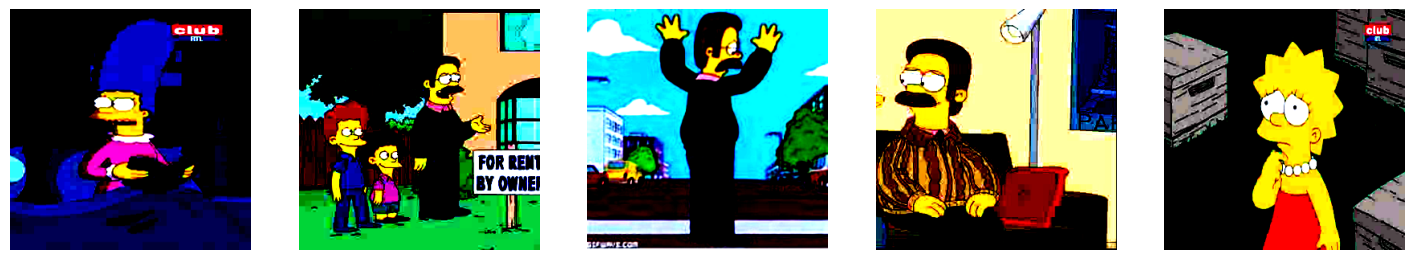

In [18]:
display_random_images(train_dataset, n=5)

## Продвинутая загрузка данных

In [15]:
def list_to_dict(paths):
    ''' Функция принимает список путей до файлов и выводит словарь, в котором ключами являются названия классов
        а значениями списки путей до каждого элемента этого класса
    '''
    
    labels = [x.parent.name for x in paths]
    labels_uniq = np.unique(labels).tolist()
    dct_path = {}
    
    for label in labels:
        dct_path[label] = []
    
    for path, label in zip(paths, labels):
        dct_path[label].append(path)
    return dct_path

In [16]:
train_path_dct = list_to_dict(train_data)
for key in train_path_dct.keys():
    # доводим количество экземпляров каждого класса до 800, оказалось плохой идеей
    while len(train_path_dct[key]) < 800: 
        train_path_dct[key] = train_path_dct[key] + train_path_dct[key]


new_train_data = list(sorted(train_path_dct.values()))

raw_data = []
for arr in new_train_data:
    raw_data += arr

In [17]:
new_train_dataset = CustomDataset(raw_data, train_transforms)
new_train_dataloader = DataLoader(dataset=new_train_dataset, batch_size=BATCH_SIZE)
new_dataloaders = {'train': new_train_dataloader, 'val': val_dataloader}

## Расширение данных за счёт аугментаций

In [18]:
new_dct = {}
dct_for_aug = {}
train_path_dct_2 = list_to_dict(train_data)
for key in train_path_dct_2.keys():
    arr = train_path_dct_2[key]
    arr.sort()

    while len(arr) < 101:
        for i in range(len(arr)):
            arr.append(arr[i])
            if len(arr) >= 101:
                break
    new_dct[key] = train_path_dct_2[key][:100]
    dct_for_aug[key] = train_path_dct_2[key][101:]


In [19]:
max_len = max([len(x) for x in dct_for_aug.values()])

dct_for_transform = {}

for key in dct_for_aug.keys():
    arr = dct_for_aug[key]
    dct_for_transform[key] = arr[:]
    arr = dct_for_transform[key]
    while len(arr) < max_len:
        for i in range(100):
            arr.append(new_dct[key][i])
            if len(arr) >= max_len:
                break
# for key in dct_for_transform:
#     print(key, len(dct_for_transform[key]))


In [20]:
main_train_list = []
addition_train_list = []
for_transform_train_list = []

for key in new_dct.keys():
    main_train_list += new_dct[key]
    addition_train_list += dct_for_aug[key]
    for_transform_train_list += dct_for_transform[key][len(dct_for_aug[key]):]
print(len(main_train_list))
print(len(addition_train_list))
print(len(for_transform_train_list))

4200
12674
53812


In [21]:
main_train_dataset = CustomDataset(main_train_list, train_transforms)
main_train_dataloader = DataLoader(dataset=main_train_dataset, batch_size=BATCH_SIZE)

addition_train_dataset = CustomDataset(addition_train_list, train_transforms)
addition_train_dataloader = DataLoader(dataset=addition_train_dataset, batch_size=BATCH_SIZE)

train_transforms_for_aug = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandAugment(),
    transforms.transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transformed_train_dataset = CustomDataset(for_transform_train_list, train_transforms_for_aug)
transformed_train_dataloader = DataLoader(dataset=transformed_train_dataset, batch_size=BATCH_SIZE)


main_dataloaders = {'train': main_train_dataloader, 'val': val_dataloader}
addition_dataloaders = {'train': addition_train_dataloader, 'val': val_dataloader}
transformed_dataloaders = {'train': transformed_train_dataloader, 'val': val_dataloader}


In [22]:
t = 0
for X, y in transformed_train_dataloader:
    t = 1
    print(X.shape, y.shape)
    if t == 1: break

torch.Size([16, 3, 300, 300]) torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Features shape of the current batch is torch.Size([16, 3, 300, 300])
Labels shape of the current batch shape is torch.Size([16])


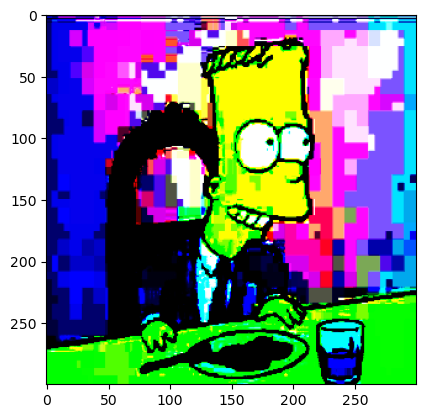

Label: 4


In [23]:
train_features, train_labels = next(iter(transformed_train_dataloader))

print(f"Features shape of the current batch is {train_features.size()}")
print(f"Labels shape of the current batch shape is {train_labels.size()}")

img = train_features[2].squeeze()
label = train_labels[2]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

## Получение отраженного датасета

In [24]:
adv_train_path_dct = list_to_dict(train_data) # Создание словаря по классам из уже разделённой обучающей выборки
for key in train_path_dct.keys():
    while len(train_path_dct[key]) < 100:  # Дополнение классов, количество экземпляров в которых < 100 
        train_path_dct[key] = train_path_dct[key] + train_path_dct[key]

adv_train_data = []
for arr in list(sorted(adv_train_path_dct.values())):
    adv_train_data += arr

adv_train_dataset = CustomDataset(adv_train_data, train_transforms) #Получение нового списка путей к файлам тестовой выборки

In [25]:
# ПО ГОРИЗОНТАЛИ
horisontal_flip_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

horisontal_flip_dataset = CustomDataset(adv_train_data, horisontal_flip_transforms)


In [26]:
# ПО ВЕРТИКАЛИ
vertical_flip_transforms = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
vertical_flip_dataset = CustomDataset(adv_train_data, vertical_flip_transforms)

In [27]:
# Объединение 2-х датасетов в 1
union_dataset = torch.utils.data.ConcatDataset([adv_train_dataset, horisontal_flip_dataset, vertical_flip_dataset])

union_dataloader = DataLoader(dataset=union_dataset, batch_size=BATCH_SIZE, shuffle=True)
union_dataloaders = {'train': union_dataloader, 'val': val_dataloader}

## Отражение только по горизонтали

In [28]:
adv_train_dataset_2 = CustomDataset(adv_train_data, train_transforms)
horisontal_flip_dataset_2 = CustomDataset(adv_train_data, horisontal_flip_transforms)
union_dataset_2 = torch.utils.data.ConcatDataset([adv_train_dataset_2, horisontal_flip_dataset_2])
union_dataloader_2 = DataLoader(dataset=union_dataset_2, batch_size=BATCH_SIZE, shuffle=True)
union_dataloaders_2 = {'train': union_dataloader_2, 'val': val_dataloader}

## Построение нейросети

In [124]:
from torch import nn

In [125]:
class MyNN(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [126]:
class MyNN_3_less(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ReLU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [127]:
# from torchinfo import summary
# summary(model_1, input_size=[1,  3, 300, 300])

In [128]:
class MyNN_mini_conv(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            # nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ReLU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [129]:
class MyNN_light(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            # nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(),
            
            # nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ReLU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [130]:
class MyNN_one_linear(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=out_shape, bias=True)
            # nn.ReLU(),
            # # nn.Linear(in_features=200, out_features=200, bias=True),
            # # nn.ReLU(),
            # nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [131]:
class MyNN_elu(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [132]:
class MyNN_stride(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
#             nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ELU(),
            
#             nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ELU(),
            
            nn.Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [133]:
class MyNN_plus(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=200, bias=True),
            nn.ELU(),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.ELU(),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.ELU(),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [134]:
class MyNN_elu_less_lin(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=100, bias=True),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [135]:
class MyNN_elu_less_lin_50(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=50, bias=True),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [136]:
class MyNN_dropout(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16384, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [137]:
class MyNN_dropout_2(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=16384, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [138]:
class MyNN_192_conv(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=12288, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [139]:
class MyNN_inplace(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(3, 3),
                     stride=(1, 1),
                     padding=(1, 1)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=248832, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [140]:
class MyNN_5x5k(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4800, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [141]:
class MyNN_5x5k_50(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4800, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [142]:
class MyNN_conv_plus(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=3072, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [143]:
class MyNN_9x9(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=192, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [144]:
class MyNN_half(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1728, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            # nn.Linear(in_features=200, out_features=200, bias=True),
            # nn.ReLU(),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [145]:
class MyNN_half_2(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1728, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=50, bias=True),
            nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [146]:
class MyNN_100(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1728, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [147]:
class MyNN_200(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1728, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [148]:
class MyNN_mach(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1728, out_features=200, bias=True),
            nn.Dropout(p=0.5),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.Dropout(p=0.5),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.Dropout(p=0.5),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.Dropout(p=0.5),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.Dropout(p=0.5),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [149]:
class MyNN_t(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=3072, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [150]:
class MyNN_alpha(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=3072, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=150, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=150, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [151]:
class MyNN_beta(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=3072, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [152]:
class MyNN_gamma(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=3072, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [153]:
class MyNN_delta(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 16,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4096, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [154]:
class MyNN_epsilon(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4096, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [155]:
class MyNN_dzeta(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 256, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1024, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [156]:
class MyNN_eta(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(128, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=800, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [157]:
class MyNN_teta(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(128, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1800, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [158]:
class MyNN_iota(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(128, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1800, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
#             nn.Linear(in_features=100, out_features=50, bias=True),
#             nn.Dropout(p=0.2),
#             nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [159]:
class MyNN_kappa(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(128, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(200, 200, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=200, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
#             nn.Linear(in_features=100, out_features=50, bias=True),
#             nn.Dropout(p=0.2),
#             nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

In [160]:
class MyNN_lambda(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 256, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
#             nn.Linear(in_features=100, out_features=50, bias=True),
#             nn.Dropout(p=0.2),
#             nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

## Лучший вариант нейросети

In [161]:
class MyNN_mu(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64,
                     kernel_size=(9, 9),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            
            nn.Conv2d(192, 192, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(192, 192, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(192, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=4800, out_features=200, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
            nn.Linear(in_features=100, out_features=out_shape, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x

## Пишем цикл обучения

In [163]:
labels_dct = dict((v, k) for k, v in bg_val_dataset.en().items())

In [164]:
from tqdm.auto import tqdm

def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    computet_data = 0
    train_loss = 0.0
    correct = 0
    for X, y in tqdm(dataloader):
    
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X)
        
        loss = loss_fn(outputs, y)
        
        loss.backward()
        
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        
        train_loss += loss.item() * X.size(0)
        correct += torch.sum(preds==y.data)
        computet_data += X.size(0)
    train_loss = train_loss / computet_data
    train_acc = correct.cpu().numpy() / computet_data
    return train_loss, train_acc

In [165]:
def predict_nn(model, test_dataloader, dct):
    model.to(device)
    model.eval()
    preds = []
    for X, y in test_dataloader:
        X = X.to(device)
        with torch.no_grad():
            pred = model(X)
        sft = nn.functional.softmax(pred, dim=-1)
        preds += [int(x) for x in torch.argmax(nn.functional.softmax(pred, dim=-1), dim=-1)]
    pred_names = []
    for item in preds:
        pred_names.append(dct[item])

    return preds, pred_names

In [166]:
def val_epoch(model, dataloader, loss_fn):
    model.eval()
    computet_data = 0
    val_loss = 0
    correct = 0
    loss_dct = {}
    for i in range(len(labels_dct.keys())):
        loss_dct[i] = [0, 0]
    
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            outputs = model(X)
        loss = loss_fn(outputs, y)        
        preds = torch.argmax(outputs, 1)
        
        val_loss += loss.item() * X.size(0)
        correct += torch.sum(preds==y.data)
        computet_data += X.size(0)
        
        predicts = [int(x) for x in torch.argmax(nn.functional.softmax(outputs, dim=-1), dim=-1)]
        y = y.to(torch.device("cpu")).numpy()
        for i in range(len(y)):
            loss_dct[y[i]][0] += 1
            if y[i] == predicts[i]:
                loss_dct[y[i]][1] += 1
                

    val_loss = val_loss / computet_data
    val_acc = correct.double() / computet_data
    return val_loss, val_acc, loss_dct

In [167]:
def train_nn(model, dataloaders, loss_fn, optimizer, epochs, sheduller=None):
    history = []
    prosess = "train loss: {}, val_loss: {}, train_acc: {}, val_acc: {}"
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, dataloaders['train'], loss_fn, optimizer)
        val_loss, val_acc, loss_dct = val_epoch(model, dataloaders['val'], loss_fn)
        
        history.append((train_loss, val_loss, train_acc, val_acc))
        
        print(prosess.format(train_loss, val_loss, train_acc, val_acc))
        
        for key, val in loss_dct.items():
            print(labels_dct[key], ':', val[0], ';', val[1], ';', '%.2f' % (val[1]/val[0]))
        if sheduller:
            sheduller.step()
    return history

In [168]:
def save_model(model, optimizer, file_name):
    checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, file_name + '.pth')

In [169]:
model = MyNN_mu(3, 42)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001, weight_decay=1e-5)
sheduller = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma = 0.5)

In [170]:
h = train_nn(model, bg_dataloaders, loss_fn, optimizer, 10, sheduller)

  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.6075960300433829, val_loss: 0.5674532562044997, train_acc: 0.6679709334823924, val_acc: 0.7035175879396985
charles_montgomery_burns : 291 ; 145 ; 0.50
enother : 306 ; 275 ; 0.90


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.5212996392159438, val_loss: 0.48178577632760283, train_acc: 0.7451089994410285, val_acc: 0.7721943048576214
charles_montgomery_burns : 291 ; 217 ; 0.75
enother : 306 ; 244 ; 0.80


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.4463395246951656, val_loss: 0.4435552260534248, train_acc: 0.7909446618222471, val_acc: 0.8090452261306533
charles_montgomery_burns : 291 ; 241 ; 0.83
enother : 306 ; 242 ; 0.79


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.400922133610727, val_loss: 0.40428982767427785, train_acc: 0.820011179429849, val_acc: 0.8090452261306533
charles_montgomery_burns : 291 ; 242 ; 0.83
enother : 306 ; 241 ; 0.79


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.320190804273873, val_loss: 0.38094255313202363, train_acc: 0.8652878703186138, val_acc: 0.8224455611390284
charles_montgomery_burns : 291 ; 228 ; 0.78
enother : 306 ; 263 ; 0.86


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.28097863571146736, val_loss: 0.3826749452594137, train_acc: 0.8831749580771381, val_acc: 0.8190954773869347
charles_montgomery_burns : 291 ; 235 ; 0.81
enother : 306 ; 254 ; 0.83


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.24645639589507198, val_loss: 0.38050962215791795, train_acc: 0.9111235326998323, val_acc: 0.8291457286432161
charles_montgomery_burns : 291 ; 222 ; 0.76
enother : 306 ; 273 ; 0.89


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.21450895592028899, val_loss: 0.3606151919468763, train_acc: 0.9228619340413639, val_acc: 0.8324958123953099
charles_montgomery_burns : 291 ; 241 ; 0.83
enother : 306 ; 256 ; 0.84


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.17481450848968552, val_loss: 0.36171021718076324, train_acc: 0.9441028507546115, val_acc: 0.8425460636515913
charles_montgomery_burns : 291 ; 233 ; 0.80
enother : 306 ; 270 ; 0.88


  0%|          | 0/112 [00:00<?, ?it/s]

train loss: 0.1453817842924908, val_loss: 0.36971360704607303, train_acc: 0.9625489100055897, val_acc: 0.8375209380234506
charles_montgomery_burns : 291 ; 247 ; 0.85
enother : 306 ; 253 ; 0.83


## Загрузка и использование модели

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
# Эти строчки нужны если мы не собираемся дообучать модель
#     for parameter in model.parameters():
#         parameter.requires_grad = False

    model.eval()
    return model

#### Поскольку соревнование проходит по метрике f-1 необходимо составить свою реализацию использования этой метрики

In [ ]:
def val_f1_score(model, val_dataloader):
    model.to(device)
    model.eval()
    preds = []
    labels = []
    t = 0
    for X, y in val_dataloader:
        X = X.to(device)
        with torch.no_grad():
            pred = model(X)
        sft = nn.functional.softmax(pred, dim=-1)
        preds += [int(x) for x in torch.argmax(nn.functional.softmax(pred, dim=-1), dim=-1)]
        labels += y
    print(f1_score(labels, preds, average='macro'))
    print(len(labels), len(preds))
    return preds, labels

In [ ]:
# Функция, необходимая для наглядной интерпретации выходов модели
def predict_nn(model, test_dataloader, dct):
    model.to(device)
    model.eval()
    preds = []
    for X, y in test_dataloader:
        X = X.to(device)
        with torch.no_grad():
            pred = model(X)
        sft = nn.functional.softmax(pred, dim=-1)
        preds += [int(x) for x in torch.argmax(nn.functional.softmax(pred, dim=-1), dim=-1)]
    pred_names = []
    for item in preds:
        pred_names.append(dct[item])

    return preds, pred_names

### Загрузка тестовых данных их обработка и формирование файла с ответами

In [ ]:
TEST_DIR = pathlib.Path('journey-springfield/testset/testset')

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
test_filenames = [path.name for path in test_files]

test_dataset = CustomDataset(test_files, val_transforms)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
predicts, predict_names = predict_nn(model_1, test_dataloader, lables_dct)

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': predict_names})
my_submit.head()

In [ ]:
# Запись в файл
my_submit.to_csv('ansvers.csv', index=False)

### Submit on Kaggle

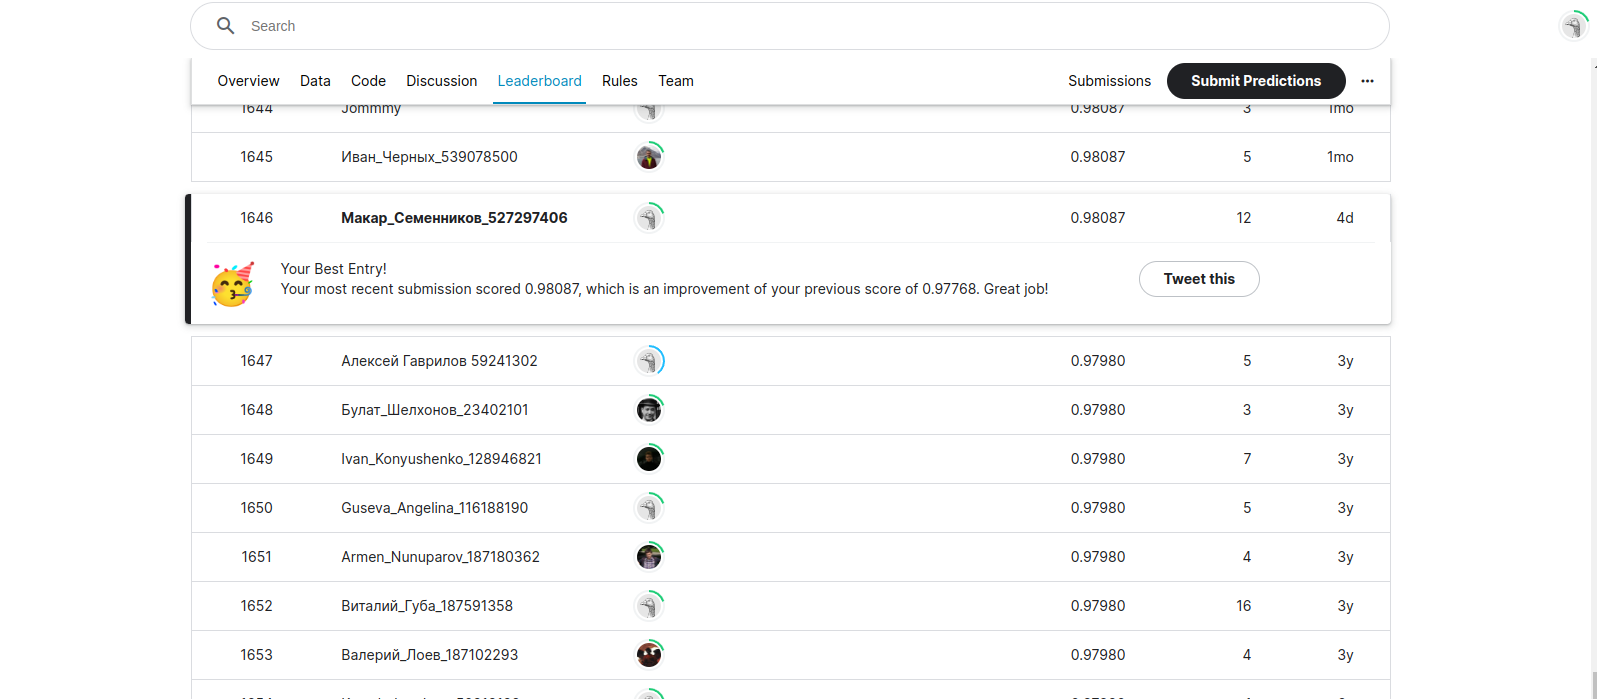

## Создание датасета для бинарной классификации
#### Была идея обучить ансамбль моделей бинарной классификации, каждая отличала свой класс от всех остальных
#### В итоге идея была признана слишком трудоемкой, но хотелось сохранить код для других проектов.

In [29]:
class CustomDatasetBin(Dataset):
    
    def __init__(self, X, y, transform):
        ''' Принимает список путей до файлов X и список строковых меток классов(предполагается 2) в y.
        '''
        self.paths = X
        self.labels = y

        
        if len(self.labels) != len(self.paths):
            print('ERROR: len(self.labels) != len(self.paths)')
        
        self.classes = np.unique(y).tolist()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
       

        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def class_to_i(self):
        return self.class_to_idx
    def en(self):
        return self.class_to_idx
    
    def load_item(self, index): 
        ''' открывает картинку по заданному пути
        '''
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __getitem__(self, index):
        '''возвращает картинку и метку класса к ней'''
        
        img = self.load_item(index)
        
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        return self.transform(img), class_idx

In [ ]:
def dct_for_binary(dct_orig):
    '''Построение словаря, в котором по каждому ключу хранится список[[],[]] в первом поле -- экземпляры 
        соответствующие классу
        ключа, во втором поле все остальные файлы выборки за исключением содержащихся в первом поле
        
        принимает словарь вида {label: [file1, file2, file3, ...]}
    '''
    dct_bin = {}
    for key in dct_orig.keys():
        dct_bin[key] = [[], []]
    for key in dct_orig.keys():
        for item in dct_orig[key]:
            dct_bin[key][0].append(item)
    
    for key_bin in dct_bin.keys():
        for key_orig in dct_orig.keys():
            if key_bin != key_orig:
                for item in dct_orig[key_orig]:
                    dct_bin[key_bin][1].append(item)
    return dct_bin

In [30]:
dct_for_bin_class = dct_for_binary(dct)
for x, y in dct_for_bin_class.items():
    
    print(x, len(y[0]), len(y[1]))

abraham_grampa_simpson 913 20020
agnes_skinner 42 20891
apu_nahasapeemapetilon 623 20310
barney_gumble 106 20827
bart_simpson 1342 19591
carl_carlson 98 20835
charles_montgomery_burns 1193 19740
chief_wiggum 986 19947
cletus_spuckler 47 20886
comic_book_guy 469 20464
disco_stu 8 20925
edna_krabappel 457 20476
fat_tony 27 20906
gil 27 20906
groundskeeper_willie 121 20812
homer_simpson 2246 18687
kent_brockman 498 20435
krusty_the_clown 1206 19727
lenny_leonard 310 20623
lionel_hutz 3 20930
lisa_simpson 1354 19579
maggie_simpson 128 20805
marge_simpson 1291 19642
martin_prince 71 20862
mayor_quimby 246 20687
milhouse_van_houten 1079 19854
miss_hoover 17 20916
moe_szyslak 1452 19481
ned_flanders 1454 19479
nelson_muntz 358 20575
otto_mann 32 20901
patty_bouvier 72 20861
principal_skinner 1194 19739
professor_john_frink 65 20868
rainier_wolfcastle 45 20888
ralph_wiggum 89 20844
selma_bouvier 103 20830
sideshow_bob 877 20056
sideshow_mel 40 20893
snake_jailbird 55 20878
troy_mcclure 8 20925

In [31]:
# Если делаем срез во втором поле массива по каждому ключу, так чтобы количество несоответствующих классу элементов был 
# равен (Или в 2 раза превосходил, если элементов < 60) количеству элементов соответствующих классу
for key in dct_for_bin_class.keys():
    random.shuffle(dct_for_bin_class[key][1])  # Перемешиваем, чтобы классы не шли друг за другом
    l = len(dct_for_bin_class[key][0])
    if l < 60:
        l *= 2
    dct_for_bin_class[key][1] = dct_for_bin_class[key][1][:l]

for x, y in dct_for_bin_class.items():
    print(x, len(y[0]), len(y[1]))

abraham_grampa_simpson 913 913
agnes_skinner 42 84
apu_nahasapeemapetilon 623 623
barney_gumble 106 106
bart_simpson 1342 1342
carl_carlson 98 98
charles_montgomery_burns 1193 1193
chief_wiggum 986 986
cletus_spuckler 47 94
comic_book_guy 469 469
disco_stu 8 16
edna_krabappel 457 457
fat_tony 27 54
gil 27 54
groundskeeper_willie 121 121
homer_simpson 2246 2246
kent_brockman 498 498
krusty_the_clown 1206 1206
lenny_leonard 310 310
lionel_hutz 3 6
lisa_simpson 1354 1354
maggie_simpson 128 128
marge_simpson 1291 1291
martin_prince 71 71
mayor_quimby 246 246
milhouse_van_houten 1079 1079
miss_hoover 17 34
moe_szyslak 1452 1452
ned_flanders 1454 1454
nelson_muntz 358 358
otto_mann 32 64
patty_bouvier 72 72
principal_skinner 1194 1194
professor_john_frink 65 65
rainier_wolfcastle 45 90
ralph_wiggum 89 89
selma_bouvier 103 103
sideshow_bob 877 877
sideshow_mel 40 80
snake_jailbird 55 110
troy_mcclure 8 16
waylon_smithers 181 181


In [32]:
def fel(lst):
    '''Функция (сокращение от features and labels) соединяет 2 списка так, что вначале идут принадлежащие классу файлы а
    затем -- не принадлежащие ему. Таким же образом составляет массив меток
    '''
    X = lst[0]+lst[1]
    y = [lst[0][0].parent.name]*len(lst[0]) + ['enother']*len(lst[1])

    return X, y

In [120]:
x1, y1 = fel(dct_for_bin_class['barney_gumble'])
print(len(x1), len(y1))

2386 2386


In [122]:
bg_train_X, bg_val_X, bg_train_y, bg_val_y = train_test_split(x1, y1, train_size=0.75, test_size=0.25)

bd_train_dataset = CustomDatasetBin(bg_train_X, bg_train_y, train_transforms)
bg_val_dataset = CustomDatasetBin(bg_val_X, bg_val_y, train_transforms)

bd_train_dataloader = DataLoader(dataset=bd_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
bg_val_dataloader = DataLoader(dataset=bg_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

bg_dataloaders = {'train': bd_train_dataloader,
                 'val': bg_val_dataloader}

In [123]:
bd_train_dataset.class_to_i()

{'charles_montgomery_burns': 0, 'enother': 1}

In [162]:
## Бинарный вариант, была идея создать ансамбль моделей
class MyNN_mu_binary(nn.Module):
    def __init__(self, input_shape, out_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 16,
                     kernel_size=(11, 11),
                     stride=(4, 4),
                     padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(11, 11), stride=(2, 2), padding=(2, 2)),
            nn.ELU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=(11, 11), stride=(2, 2), padding=(2, 2)),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
#             nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=50, bias=True),
            nn.Dropout(p=0.2),
            nn.ELU(inplace=True),
#             nn.Linear(in_features=200, out_features=100, bias=True),
#             nn.Dropout(p=0.2),
#             nn.ELU(inplace=True),
            nn.Linear(in_features=50, out_features=2, bias=True)
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.classifier(x)

        return x